In [1]:
import yasa
import mne
import matplotlib.pyplot as plt
import numpy as np
import statistics
import pybv
from scipy import signal
from scipy import io
import pymatreader
from mne.io import Raw
from mne import read_events
import wonambi
import h5py
import csv
import pandas as pd
from collections import Counter

In [2]:
# preliminaires
datapath = r'C:\Users\siann\Data\spindle_ppTMS\EEG'
subjects = 'sub-02'
session = ['ses-exp_01', 'ses-exp_02', 'ses-exp_03']
condition_peak = 'S155'
condition_trough = 'S156'
condition_rising = 'S157'
condition_falling = 'S158'
condition_sp_free = 'S159'
sf = 5000

In [3]:

# append thress different recordings from the same night
data_raw_list = []

for i in range(len(session)):
    data_raw_i = mne.io.read_raw_brainvision(datapath + '/' + subjects + '/' + session[i] + '/' + 'spindle-ppTMS_' + subjects + '_' + session[i] + '.vhdr', preload=True)
    data_raw_i.resample(100)
    data_raw_i.set_eeg_reference(ref_channels=['TP9', 'TP10']) # average mastoid reference
    data_raw_list.append(data_raw_i)

data_raw_all = mne.concatenate_raws(data_raw_list)
data_raw_all.filter(0.1, 40) # bp filter
data = data_raw_all.get_data() # Retrieve the data as a numpy array

# Check the shape of the data
print(np.shape(data))

Extracting parameters from C:\Users\siann\Data\spindle_ppTMS\EEG/sub-02/ses-exp_01/spindle-ppTMS_sub-02_ses-exp_01.vhdr...


Setting channel info structure...
Reading 0 ... 32385722  =      0.000 ...  6477.144 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Extracting parameters from C:\Users\siann\Data\spindle_ppTMS\EEG/sub-02/ses-exp_02/spindle-ppTMS_sub-02_ses-exp_02.vhdr...
Setting channel info structure...
Reading 0 ... 14991023  =      0.000 ...  2998.205 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Extracting parameters from C:\Users\siann\Data\spindle_ppTMS\EEG/sub-02/ses-exp_03/spindle-ppTMS_sub-02_ses-exp_03.vhdr...
Setting channel info structure...
Reading 0 ... 4927619  =      0.000 ...   985.524 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


(70, 1046086)


In [5]:
# yasa sleep stageing
sleep_stages = yasa.SleepStaging(data_raw_all, eeg_name = 'C4', eog_name="VEOG", emg_name="EMG") 
values = sleep_stages.predict() # predict the sleep stages
from yasa import Hypnogram
hyp = Hypnogram(values, n_stages=5) # create yasa Hypnogram object
hyp.sleep_statistics() # get sleep statistics

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return self.hypno.replace(self.mapping).astype(np.int16)
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: The behavior of Series.replace (and Da

{'TIB': 174.0,
 'SPT': 167.0,
 'WASO': 83.0,
 'TST': 84.0,
 'SE': 48.2759,
 'SME': 50.2994,
 'SFI': 6.0714,
 'SOL': 7.0,
 'SOL_5min': 8.0,
 'Lat_REM': 75.5,
 'WAKE': 90.0,
 'N1': 1.5,
 'N2': 48.0,
 'N3': 20.5,
 'REM': 14.0,
 '%N1': 1.7857,
 '%N2': 57.1429,
 '%N3': 24.4048,
 '%REM': 16.6667}

c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return self.hypno.replace(self.mapping).astype(np.int16)
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  return self.hypno.replace(self.mapping).astype(np.int16)


<Axes: xlabel='Time [hrs]', ylabel='Stage'>

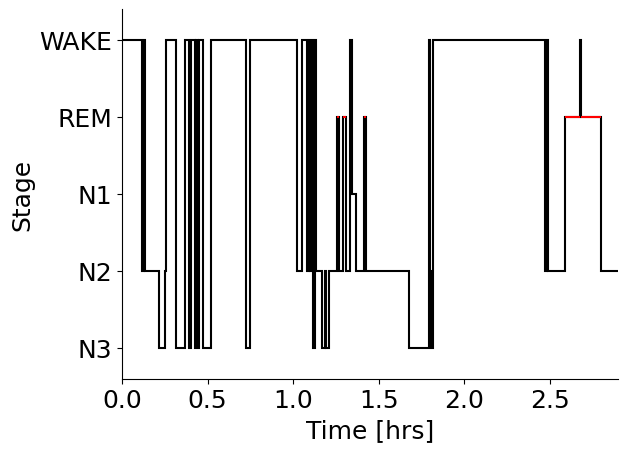

In [6]:
hyp.plot_hypnogram()

In [7]:
# detect spindles 

hyp_up = hyp.upsample_to_data(sf = 1/30, data = data_raw_all)
data_C3_C4 = data_raw_all.get_data(['C3', 'C4'], units="uV")
spindles_c3_c4 = yasa.spindles_detect(data_C3_C4, include=(2,3), ch_names = ('C3', 'C4'), hypno=hyp_up, sf = 100)
spindles_c3_c4 = spindles_c3_c4.summary()
# when you run it on all the channels, do spindles.summary(grp_chan=True, grp_stage=True, aggfunc='mean')
print(spindles_c3_c4)

c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return self.hypno.replace(self.mapping).astype(np.int16)
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  return self.hypno.replace(self.mapping).astype(np.int16)
03-Apr-24 12:35:50 | WARNING | Hypnogram is SHORTER than data by 20.86 seconds. Padding hypnogram with last value to match data.size.


        Start      Peak       End  Duration  Amplitude        RMS  AbsPower  \
0      494.04    494.77    495.06      1.02  48.077588   9.653255  1.853741   
1      505.53    506.59    506.98      1.45  78.355815  15.244214  2.120461   
2      521.52    521.78    522.07      0.55  56.005581  13.478839  2.052828   
3      565.20    565.72    566.02      0.82  53.113523  12.360649  2.244682   
4      571.53    571.79    572.50      0.97  56.216210  13.104689  2.291850   
..        ...       ...       ...       ...        ...        ...       ...   
143   9287.20   9287.56   9287.90      0.70  69.736469  16.355941  2.498262   
144   9298.21   9298.67   9298.88      0.67  42.314287  10.792671  2.249739   
145  10143.75  10144.20  10144.64      0.89  57.194914  12.578930  1.980666   
146  10441.09  10441.29  10441.87      0.78  56.664332  13.051874  2.301885   
147  10456.41  10456.64  10456.92      0.51  35.750031   8.419190  2.050149   

     RelPower  Frequency  Oscillations  Symmetry  S

In [9]:
mean_RMS = statistics.mean(spindles_c3_c4.RMS)
print('RMS for sub-02:', mean_RMS)
mean_SpF = statistics.mean(spindles_c3_c4.Frequency)
print('SpF for sub-02:', mean_SpF)

RMS for sub-02: 13.000164266411213
SpF for sub-02: 13.195800663465786


In [10]:
# store stimulation times in a list
stimulation_times_list = [] 
with open(r"C:\Users\siann\Data\spindle_ppTMS\EEG\sub-02\data_sub-02_all_ses_trialmatrix.csv", 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        first_value = int(row[0])
        stimulation_time = (first_value + 1500) // sf  # get stimulation time in seconds 
        stimulation_times_list.append(stimulation_time)  

print(stimulation_times_list)

[4546, 4590, 4762, 4806, 4973, 5057, 5088, 5108, 5221, 5250, 5328, 5427, 5460, 5476, 5493, 5564, 5641, 5683, 5694, 5718, 5767, 5831, 5889, 5903, 5930, 5983, 6080, 6090, 6130, 6163, 6243, 6258, 6293, 6354, 6371, 6496, 6531, 6541, 6566, 6631, 6701, 6725, 6764, 6773, 6917, 6926, 6941, 6950, 6975, 7011, 7049, 7094, 7162, 7238, 7298, 7381, 7401, 7437, 7515, 7528, 7589, 7631, 7707, 7718, 7748, 7795, 7859, 7895, 7943, 7953, 7981, 16008, 16124, 16219, 16492, 16642, 16715, 16742, 16800, 16810, 16903, 16930]


In [11]:
# count how many times stimulation occured in an interval within +- 0.5 sec relative to the detected spindle peak

stimulation_times_df = pd.DataFrame({'Stimulation Times (sec)':stimulation_times_list})
stimulation_times_df['co_occur'] = False
stimulation_times_df['co_occur_slowwave_segment_index'] = np.NaN
stimulation_times_df['co_occur_slowwave_trough_time'] = np.NaN
for index, peak_time in spindles_c3_c4['Peak'].items():
    before_peak = peak_time - 0.5
    after_peak = peak_time + 0.5
    for i, row  in stimulation_times_df.iterrows():
        if (before_peak <= row['Stimulation Times (sec)'] <= after_peak): 
            stimulation_times_df.at[i, 'co_occur'] = True
            stimulation_times_df.at[i, 'co_occur_slowwave_segment_index'] = index
            stimulation_times_df.at[i, 'co_occur_slowwave_trough_time'] = peak_time
number_co_occurences = Counter(stimulation_times_df['co_occur'])
print(number_co_occurences)
print(stimulation_times_df)

Counter({False: 79, True: 3})
    Stimulation Times (sec)  co_occur  co_occur_slowwave_segment_index  \
0                      4546     False                              NaN   
1                      4590     False                              NaN   
2                      4762     False                              NaN   
3                      4806     False                              NaN   
4                      4973     False                              NaN   
..                      ...       ...                              ...   
77                    16742     False                              NaN   
78                    16800     False                              NaN   
79                    16810     False                              NaN   
80                    16903     False                              NaN   
81                    16930     False                              NaN   

    co_occur_slowwave_trough_time  
0                             NaN  
1        

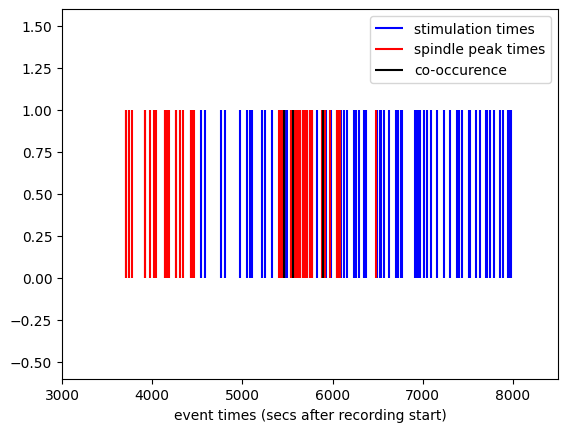

In [22]:
# plot spindle peaks and stimulation times 

plt.eventplot(stimulation_times_list, lineoffsets = 0.5, colors='b')
plt.eventplot(spindles_c3_c4['Peak'], lineoffsets = 0.5, colors ='r')
plt.eventplot(stimulation_times_df['Stimulation Times (sec)'][stimulation_times_df['co_occur'] == True], lineoffsets = 0.5, colors ='k')
plt.xlabel("event times (secs after recording start)") 
plt.xlim(3000, 8500)
plt.legend(['stimulation times', 'spindle peak times', 'co-occurence'])
plt.show()